In [1]:
!pip install pyLDAvis

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from pprint import pprint
import string
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install gensim

In [2]:
df = pd.read_csv('fin.csv', error_bad_lines=False)

C:\Users\tradi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 63671: expected 5 fields, saw 6\nSkipping line 66166: expected 5 fields, saw 6\n'


In [3]:
df

,conversationId,turnNumber,utteranceId,utterance,authorRole
0,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,0,acs-1757d840-5853-4752-b88d-d784e6ba5832,"Hello there, how may I help you today?",agent
1,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,1,acs-b9b6db75-b552-4704-a74f-d7c38b3c40c1,Hi....i need to check my balance,customer
2,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,2,acs-1539335e-cf44-4de9-b737-b2b347919fe9,"Sure thing, could you please help me out with ...",agent
3,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,3,acs-888ed142-16ad-466f-b2d5-66aec7095929,7766,customer
4,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,4,acs-96d4bda7-3de8-4eb6-a0d5-167e5d8684fe,Could you also please help me with your full n...,agent
...,...,...,...,...,...
157222,acs-23dbd0a0-9d49-4ffc-8c58-838fa2b3051d-1,15,acs-3b736bf2-edec-4cf1-ae76-1a822ee2d849,Sure! Please allow me a minute while I work on...,agent
157223,acs-23dbd0a0-9d49-4ffc-8c58-838fa2b3051d-1,16,acs-d85ef996-31ed-40e2-8d99-b54ec87ba518,OK,customer
157224,acs-23dbd0a0-9d49-4ffc-8c58-838fa2b3051d-1,17,acs-dffdb503-6844-41a1-8ae5-e7ed5b5b2f7a,Thanks for your patience. The transfer has bee...,agent
157225,acs-23dbd0a0-9d49-4ffc-8c58-838fa2b3051d-1,18,acs-3d081dde-a5d7-41cf-a46a-bcda9a7ee96c,OK THANK,customer


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157227 entries, 0 to 157226
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   conversationId  157227 non-null  object
 1   turnNumber      157227 non-null  int64 
 2   utteranceId     157227 non-null  object
 3   utterance       157227 non-null  object
 4   authorRole      157227 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB


In [4]:
df1 = df.drop(['conversationId', 'turnNumber', 'utteranceId'], axis=1)

In [5]:
print(df1)

                                                utterance authorRole
0                  Hello there, how may I help you today?      agent
1                        Hi....i need to check my balance   customer
2       Sure thing, could you please help me out with ...      agent
3                                                    7766   customer
4       Could you also please help me with your full n...      agent
...                                                   ...        ...
157222  Sure! Please allow me a minute while I work on...      agent
157223                                                 OK   customer
157224  Thanks for your patience. The transfer has bee...      agent
157225                                          OK THANK    customer
157226  You're most welcome! Thank you for reaching ou...      agent

[157227 rows x 2 columns]


In [6]:
pd.set_option('display.max_colwidth', None)
df1

,utterance,authorRole
0,"Hello there, how may I help you today?",agent
1,Hi....i need to check my balance,customer
2,"Sure thing, could you please help me out with your full name and last 4 digits of your SSN?",agent
3,7766,customer
4,Could you also please help me with your full name?,agent
...,...,...
157222,Sure! Please allow me a minute while I work on your request.,agent
157223,OK,customer
157224,Thanks for your patience. The transfer has been successfully initiated. You’ll be receiving a confirmation e-mail shortly. Is there anything else I can do for you today?,agent
157225,OK THANK,customer


In [10]:
df1['authorRole'].value_counts()

customer    80682
agent       76545
Name: authorRole, dtype: int64

In [18]:
grp_df1 = df1['utterance'].groupby(df1['authorRole'])

In [21]:
print(grp_df1.count())

authorRole
agent       76545
customer    80682
Name: utterance, dtype: int64


In [29]:
df1['authorRole'] = agent

NameError: name 'agent' is not defined

In [7]:
cust_df = df1[df1["authorRole"] == 'customer'] 

In [8]:
cust_df

,utterance,authorRole
1,Hi....i need to check my balance,customer
3,7766,customer
5,mani kumar,customer
7,7676,customer
10,ok sir,customer
...,...,...
157217,OK I NEED TRANSFER MONEY TO ANOTHER A/C,customer
157219,2597,customer
157221,250$,customer
157223,OK,customer


In [9]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80682 entries, 1 to 157225
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   utterance   80682 non-null  object
 1   authorRole  80682 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [10]:
agent_df = df1[df1["authorRole"] == 'agent'] 

In [11]:
agent_df

,utterance,authorRole
0,"Hello there, how may I help you today?",agent
2,"Sure thing, could you please help me out with your full name and last 4 digits of your SSN?",agent
4,Could you also please help me with your full name?,agent
6,Great! Could you please help me out with the last 4 digits of your account number?,agent
8,Thank you for the details. Please allow me a moment while I check with the account.,agent
...,...,...
157218,"Sure, please could you also share the account number to which you would like to transfer?",agent
157220,Perfect! How much would you want to transfer?,agent
157222,Sure! Please allow me a minute while I work on your request.,agent
157224,Thanks for your patience. The transfer has been successfully initiated. You’ll be receiving a confirmation e-mail shortly. Is there anything else I can do for you today?,agent


In [12]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

<>:4: DeprecationWarning: invalid escape sequence \)
<>:5: DeprecationWarning: invalid escape sequence \W
<>:4: DeprecationWarning: invalid escape sequence \)
<>:5: DeprecationWarning: invalid escape sequence \W
C:\Users\tradi\AppData\Local\Temp/ipykernel_7084/547513637.py:4: DeprecationWarning: invalid escape sequence \)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
C:\Users\tradi\AppData\Local\Temp/ipykernel_7084/547513637.py:5: DeprecationWarning: invalid escape sequence \W
  text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))


In [13]:
cust_df['utterance'] = cust_df['utterance'].apply(preprocessor)

C:\Users\tradi\AppData\Local\Temp/ipykernel_7084/4070076965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_df['utterance'] = cust_df['utterance'].apply(preprocessor)


In [14]:
cust_df.iloc[0,0]

'hi i need to check my balance'

In [15]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [16]:
# apply the function on the review column

cust_df['utterance'] = cust_df['utterance'].apply(lambda x: tokenizer.tokenize(x.lower()))

C:\Users\tradi\AppData\Local\Temp/ipykernel_7084/2272643876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_df['utterance'] = cust_df['utterance'].apply(lambda x: tokenizer.tokenize(x.lower()))


In [17]:
# import the needed library which contains the stopwords
from nltk.corpus import stopwords

In [18]:
# assign the stopwords to a variable stop
stop = set(stopwords.words('english'))

In [19]:
# a function to remove stop words from the data

def remove_stop(text):
    word = [w for w in text if w not in stop]
    return word

In [20]:
cust_df['utterance'] = cust_df['utterance'].apply(lambda x: remove_stop(x))

C:\Users\tradi\AppData\Local\Temp/ipykernel_7084/693402793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_df['utterance'] = cust_df['utterance'].apply(lambda x: remove_stop(x))


In [21]:
# import the needed library to use wordnet

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tradi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# import the steming libraries to be used

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [23]:
# initialise the lemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    word = [lemmatizer.lemmatize(w) for w in text]
    return word

In [25]:
# apply the lemmatizer function on the review column

cust_df['utterance'] = cust_df['utterance'].apply(lambda x: lemmatize(x))

C:\Users\tradi\AppData\Local\Temp/ipykernel_7084/739428495.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_df['utterance'] = cust_df['utterance'].apply(lambda x: lemmatize(x))


In [26]:
# initialise the porter and assign it to a function

porter = PorterStemmer()
def port(text):
    word_port = [porter.stem(i) for i in text]
    return word_port

In [27]:
cust_df['utterance'] = cust_df['utterance'].apply(lambda x: port(x))

C:\Users\tradi\AppData\Local\Temp/ipykernel_7084/1865250808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_df['utterance'] = cust_df['utterance'].apply(lambda x: port(x))


In [28]:
print(cust_df['utterance'])

1                     [hi, need, check, balanc]
3                                        [7766]
5                                 [mani, kumar]
7                                        [7676]
10                                    [ok, sir]
                          ...                  
157217    [ok, need, transfer, money, anoth, c]
157219                                   [2597]
157221                                    [250]
157223                                     [ok]
157225                              [ok, thank]
Name: utterance, Length: 80682, dtype: object


In [32]:
cust_df['utterance'] = cust_df['utterance'].astype('str')

C:\Users\tradi\AppData\Local\Temp/ipykernel_7084/3545710265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_df['utterance'] = cust_df['utterance'].astype('str')


In [59]:
#text_list=df1['utterance'].values.tolist()

## create document-term matrix using count vectorizer

In [34]:
from sklearn.feature_extraction.text import CountVectorizer 
# create document term matrix
min_df = 4 # minimum required occurences of a word, e.g 4
max_features = 10000 # max number of unique words, e.g 10000

vectorizer = CountVectorizer(
              min_df=min_df, 
              max_features=max_features, 
              token_pattern='[a-zA-Z0-9]{3,}', # use tokenizer we defined before
              ngram_range=(2,3)) # we use unigram & bigram
X = vectorizer.fit_transform(cust_df['utterance'])


In [ ]:
#word cloud

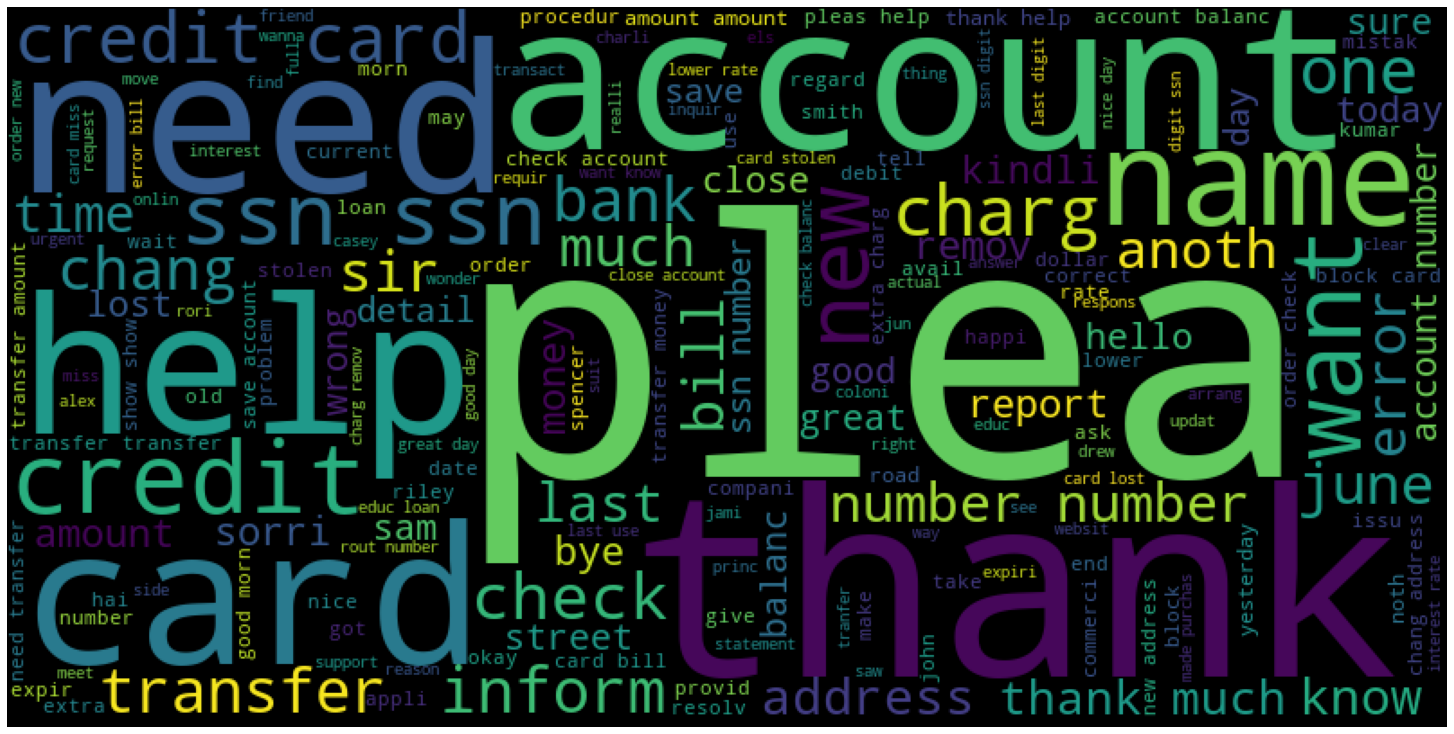

In [38]:
from wordcloud import WordCloud
for_wordcloud = vectorizer.get_feature_names()
for_wordcloud = for_wordcloud
for_wordcloud_str = ' '.join(for_wordcloud)

wordcloud = WordCloud(width=800, height=400, background_color ='black',
                      min_font_size = 7).generate(for_wordcloud_str)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('cust_wc.jpg')
plt.show()



In [92]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.figure(2, figsize=(12, 12/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.savefig('cust_top10.jpg')
    plt.show()

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tradi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


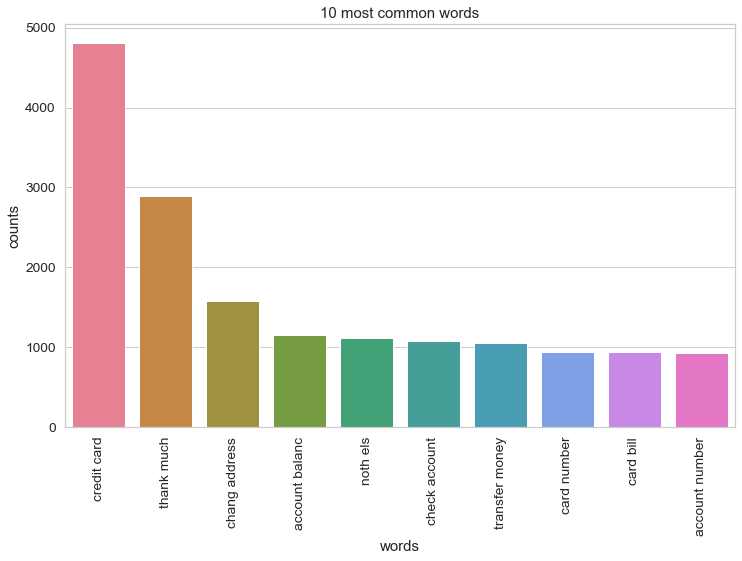

In [93]:
# Visualise the 10 most common words
plot_10_most_common_words(X, vectorizer)

In [41]:
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=50,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(X)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', max_iter=50, n_jobs=-1,
                          random_state=100)


In [ ]:
#n_components=10,               
                                      #max_iter=20
#Log Likelihood:  -729671.8624864527
#Perplexity:  634.7418890195506

In [42]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(X))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(X))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -729469.4110358962
Perplexity:  633.6064127042446
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 50,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [97]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


In [99]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, vectorizer, 15)

Topics found via LDA:

Topic #0:
credit card card number lost credit lost credit card credit card number error credit error credit card need help card stolen credit card stolen report error report error credit want report card last last week

Topic #1:
new address save account date 2018 extra charg chang new 2018 amount chang new address take time last month need chang new last credit card last credit pleas disconnect new address credit address save

Topic #2:
lower rate new lower new lower rate compani new compani new lower want know saw commerci know compani new rate saw lower rate saw rate saw commerci commerci avail need know saw commerci avail rate commerci

Topic #3:
thank help need chang chang address need chang address great thank address associ els thank good day chang address associ associ credit associ credit card address associ credit noth els thank good bye inform thank

Topic #4:
thank much thank inform much help thank much help card charg credit card charg get inform car

In [94]:
# Print the topics found by the LDA model
n_top_words = 10
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = vectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

AttributeError: 'LatentDirichletAllocation' object has no attribute 'topic_word_'

In [ ]:
Grid search
best model

In [ ]:
# Dominant topic in each document

In [45]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(X)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(cust_df['utterance']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'blue' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.760000,0.010000,0.010000,17
Doc1,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc2,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc3,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc4,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc5,0.020000,0.020000,0.020000,0.020000,0.020000,0.350000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.350000,0.020000,0.020000,5
Doc6,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc7,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc8,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc9,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0


In [ ]:
# Review topics distribution across documents

In [46]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,51297
1,4,2930
2,12,2275
3,17,2264
4,3,1868
5,1,1696
6,9,1685
7,14,1657
8,16,1461
9,7,1417


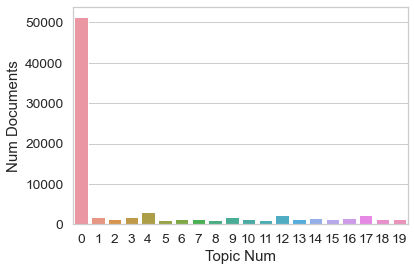

In [109]:
sns.barplot(x='Topic Num', y ='Num Documents',data=df_topic_distribution)
plt.savefig('dominant_topic_cust.jpg')

In [121]:
def prepareLDAData(lda_model, lda_df, vectorizer):
    data = {
        'vocab': vocab,
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':vectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

# load the pre-prepared pyLDAvis data
lda_data = prepareLDAData(lda_model=lda_model, lda_df=lda_df, vectorizer=vectorizer)
prepared_data = pyLDAvis.prepare(**lda_data)
pyLDAvis.display(prepared_data)

NameError: name 'lda_df' is not defined

In [47]:
import sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X, vectorizer, mds='tsne')
panel

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tradi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'sq

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0      -10.878068   10.538728       1        1  9.041289
17     -60.884026  -75.591820       2        1  7.855063
6       -2.336119  -53.289074       3        1  7.491762
2      -61.385319  -12.914634       4        1  5.832602
13     -28.737743  126.296997       5        1  5.177718
15       1.066606 -123.552811       6        1  5.010669
8       45.140720   -7.947869       7        1  4.955728
18    -140.795975  -98.530548       8        1  4.788455
10      61.531681  -83.240562       9        1  4.785963
3      -72.563057 -140.396881      10        1  4.780665
1       15.984491   63.578186      11        1  4.633021
19    -160.851624   68.945145      12        1  4.526025
11      85.961830   51.922935      13        1  4.418849
5      -99.020836  109.936348      14        1  4.285013
9     -176.764130   -8.681684      15        1  4.238432
4     -117.189880  -37.420200      16        1  3.908827
7      108.829918  -22.946203      17        1  3.727684
16      47.588097  121.934814      18        1  3.676234
14    -106.467834   30.176889      19        1  3.571876
12     -50.613804   59.328842      20        1  3.294127, topic_info=                 Term         Freq        Total Category  logprob  loglift
4047       thank much  2451.000000  2451.000000  Default  30.0000  30.0000
1171      credit card  4465.000000  4465.000000  Default  29.0000  29.0000
2837         noth els   980.000000   980.000000  Default  28.0000  28.0000
938     chang address  1533.000000  1533.000000  Default  27.0000  27.0000
302    account number   937.000000   937.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
4136       thank that    13.768020    14.682243  Topic20  -5.6004   3.3487
4165  that thank alot    13.063212    13.977434  Topic20  -5.6529   3.3454
744          bye that    12.758540    13.672762  Topic20  -5.6765   3.3438
3975   thank bye that    12.758540    13.672762  Topic20  -5.6765   3.3438
1600        gold loan    35.072162    56.810682  Topic20  -4.6653   2.9307

[650 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
18       19  0.960665            1111 1111
53       13  0.975778            15th june
65       17  0.976179            18th june
89       11  0.992721          2018 amount
94       20  0.976071           2018 charg
...     ...       ...                  ...
4575     15  0.978612      would like know
4578      3  0.979170    would like report
4579     13  0.993109  would like transfer
4587     20  0.932340            wow thank
4615      8  0.988849            yeah sure

[622 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 18, 7, 3, 14, 16, 9, 19, 11, 4, 2, 20, 12, 6, 10, 5, 8, 17, 15, 13])

In [61]:
pyLDAvis.save_html(panel, 'lda_cust_topic_20_iter.html')

In [ ]:
# Topic keywords

In [48]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000 000,100 account,100 check,100 dollar,100 main,100 main box,100 new,100 save,100 save account,100 show,...,yesterday morn,yesterday night,yesterday order,yesterday order check,yesterday pleas,yesterday pleas block,yesterday pleas help,york 10010,yuvika ssn,zip code
Topic0,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.050000,0.05,0.05
Topic1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,8.437247,0.050000,0.050000,0.05,0.05,0.05,11.947255,0.05,0.05
Topic2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.050000,0.05,0.05
Topic3,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.050000,9.868204,6.681307,0.05,0.05,0.05,0.050000,0.05,0.05
Topic4,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.050000,0.05,0.05


### Top 15 topic keywords

In [49]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,credit card,card number,lost credit,lost credit card,credit card number,error credit,error credit card,need help,card stolen,credit card stolen,report error,report error credit,want report,card last,last week
Topic 1,new address,save account,date 2018,extra charg,chang new,2018 amount,chang new address,take time,last month,need chang new,last credit,last credit card,pleas disconnect,new address credit,address save
Topic 2,lower rate,new lower,new lower rate,compani new,compani new lower,want know,saw commerci,know compani new,rate saw,lower rate saw,rate saw commerci,need know,commerci avail,saw commerci avail,rate commerci
Topic 3,thank help,need chang,chang address,need chang address,great thank,address associ,els thank,good day,chang address associ,associ credit,associ credit card,address associ credit,noth els thank,good bye,hai need
Topic 4,thank much,thank inform,much help,thank much help,card charg,credit card charg,get inform,card charg remov,polic station,much great,thank much great,much byee,thank much byee,great thank much,take care
Topic 5,rout number,bank rout,bank rout number,order check,know compani,know bank,let know,know bank rout,want order,need order,one expir,thank need,old one,old one expir,want order check
Topic 6,credit card,card bill,credit card bill,would like,address credit,address credit card,chang address credit,charg remov,chang address,bill charg,show error,like chang,bill show,card bill charg,card bill show
Topic 7,last four,four digit,last four digit,pleas transfer,four digit ssn,okay thank,thank sir,polic report,visit bank,18th june,four digit account,account save,okay thank much,account save account,bank websit
Topic 8,transfer money,want transfer,anoth account,want transfer money,money anoth,account anoth,transfer money anoth,money anoth account,money account,transfer money account,report credit,report credit card,money account anoth,account anoth account,account help
Topic 9,ssn number,june 2018,2018 time,know account,know account balanc,pleas close,use 2018,date 2018 time,could help,want know account,lost card,hello need,transfer 500,card pleas,close card


### cluster documents that share similar topics and plot using  k-means

In [50]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.3   0.21  0.21  0.23  0.26  0.2   0.22  0.21  0.2   0.22  0.21  0.2
   0.24  0.21  0.22  0.22  0.21  0.27  0.21  0.21]
 [ 0.9  -0.05 -0.05 -0.07 -0.1  -0.04  0.04 -0.03 -0.03 -0.04 -0.04 -0.04
  -0.06 -0.02 -0.03 -0.07 -0.05 -0.39 -0.02 -0.04]]
Perc of Variance Explained: 
 [0.   0.11]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

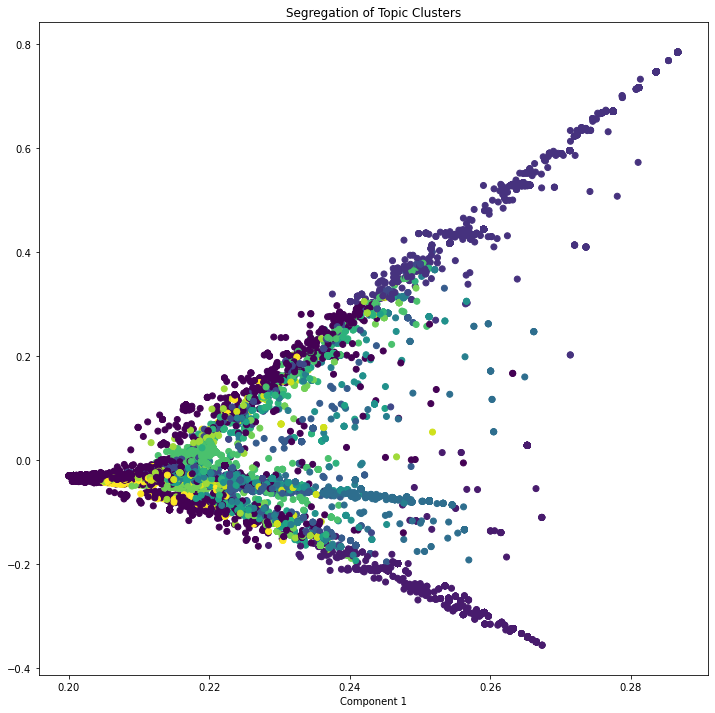

In [51]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

## Num of topics 20, 50 iterations

In [41]:
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=50,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(X)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', max_iter=50,
                          n_components=20, n_jobs=-1, random_state=100)


In [52]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(X))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(X))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -708540.7802762951
Perplexity:  526.5441254083673
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 50,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [53]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(X)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(cust_df['utterance']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'blue' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.760000,0.010000,0.010000,17
Doc1,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc2,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc3,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc4,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc5,0.020000,0.020000,0.020000,0.020000,0.020000,0.350000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.350000,0.020000,0.020000,5
Doc6,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc7,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc8,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc9,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0


In [ ]:
#Review topics distribution across documents

In [54]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,51297
1,4,2930
2,12,2275
3,17,2264
4,3,1868
5,1,1696
6,9,1685
7,14,1657
8,16,1461
9,7,1417


# top 15 keywords

In [55]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,credit card,card number,lost credit,lost credit card,credit card number,error credit,error credit card,need help,card stolen,credit card stolen,report error,report error credit,want report,card last,last week
Topic 1,new address,save account,date 2018,extra charg,chang new,2018 amount,chang new address,take time,last month,need chang new,last credit,last credit card,pleas disconnect,new address credit,address save
Topic 2,lower rate,new lower,new lower rate,compani new,compani new lower,want know,saw commerci,know compani new,rate saw,lower rate saw,rate saw commerci,need know,commerci avail,saw commerci avail,rate commerci
Topic 3,thank help,need chang,chang address,need chang address,great thank,address associ,els thank,good day,chang address associ,associ credit,associ credit card,address associ credit,noth els thank,good bye,hai need
Topic 4,thank much,thank inform,much help,thank much help,card charg,credit card charg,get inform,card charg remov,polic station,much great,thank much great,much byee,thank much byee,great thank much,take care
Topic 5,rout number,bank rout,bank rout number,order check,know compani,know bank,let know,know bank rout,want order,need order,one expir,thank need,old one,old one expir,want order check
Topic 6,credit card,card bill,credit card bill,would like,address credit,address credit card,chang address credit,charg remov,chang address,bill charg,show error,like chang,bill show,card bill charg,card bill show
Topic 7,last four,four digit,last four digit,pleas transfer,four digit ssn,okay thank,thank sir,polic report,visit bank,18th june,four digit account,account save,okay thank much,account save account,bank websit
Topic 8,transfer money,want transfer,anoth account,want transfer money,money anoth,account anoth,transfer money anoth,money anoth account,money account,transfer money account,report credit,report credit card,money account anoth,account anoth account,account help
Topic 9,ssn number,june 2018,2018 time,know account,know account balanc,pleas close,use 2018,date 2018 time,could help,want know account,lost card,hello need,transfer 500,card pleas,close card


In [56]:
import sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X, vectorizer, mds='tsne')
panel

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tradi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'sq

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0      -10.878068   10.538728       1        1  9.041289
17     -60.884026  -75.591820       2        1  7.855063
6       -2.336119  -53.289074       3        1  7.491762
2      -61.385319  -12.914634       4        1  5.832602
13     -28.737743  126.296997       5        1  5.177718
15       1.066606 -123.552811       6        1  5.010669
8       45.140720   -7.947869       7        1  4.955728
18    -140.795975  -98.530548       8        1  4.788455
10      61.531681  -83.240562       9        1  4.785963
3      -72.563057 -140.396881      10        1  4.780665
1       15.984491   63.578186      11        1  4.633021
19    -160.851624   68.945145      12        1  4.526025
11      85.961830   51.922935      13        1  4.418849
5      -99.020836  109.936348      14        1  4.285013
9     -176.764130   -8.681684      15        1  4.238432
4     -117.189880  -37.420200      16        1  3.908827
7      108.829918  -22.946203      17        1  3.727684
16      47.588097  121.934814      18        1  3.676234
14    -106.467834   30.176889      19        1  3.571876
12     -50.613804   59.328842      20        1  3.294127, topic_info=                 Term         Freq        Total Category  logprob  loglift
4047       thank much  2451.000000  2451.000000  Default  30.0000  30.0000
1171      credit card  4465.000000  4465.000000  Default  29.0000  29.0000
2837         noth els   980.000000   980.000000  Default  28.0000  28.0000
938     chang address  1533.000000  1533.000000  Default  27.0000  27.0000
302    account number   937.000000   937.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
4136       thank that    13.768020    14.682243  Topic20  -5.6004   3.3487
4165  that thank alot    13.063212    13.977434  Topic20  -5.6529   3.3454
744          bye that    12.758540    13.672762  Topic20  -5.6765   3.3438
3975   thank bye that    12.758540    13.672762  Topic20  -5.6765   3.3438
1600        gold loan    35.072162    56.810682  Topic20  -4.6653   2.9307

[650 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
18       19  0.960665            1111 1111
53       13  0.975778            15th june
65       17  0.976179            18th june
89       11  0.992721          2018 amount
94       20  0.976071           2018 charg
...     ...       ...                  ...
4575     15  0.978612      would like know
4578      3  0.979170    would like report
4579     13  0.993109  would like transfer
4587     20  0.932340            wow thank
4615      8  0.988849            yeah sure

[622 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 18, 7, 3, 14, 16, 9, 19, 11, 4, 2, 20, 12, 6, 10, 5, 8, 17, 15, 13])

In [60]:
pyLDAvis.save_html(panel, 'lda.html')

In [42]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

AttributeError: 'LatentDirichletAllocation' object has no attribute 'show_topics'

In [43]:
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=100,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(X)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', max_iter=100,
                          n_components=20, n_jobs=-1, random_state=100)


In [44]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(X))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(X))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -708489.0869352894
Perplexity:  526.303457119581
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 100,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [45]:
import sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X, vectorizer, mds='tsne')
panel

C:\Users\tradi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared b

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0      -10.878068   10.538728       1        1  9.041507
17     -60.884026  -75.591820       2        1  7.855170
6       -2.336119  -53.289074       3        1  7.491202
2      -61.385319  -12.914634       4        1  5.832602
13     -28.737743  126.296997       5        1  5.177806
15       1.066606 -123.552811       6        1  5.010744
8       45.140720   -7.947869       7        1  4.955407
18    -140.795975  -98.530548       8        1  4.788330
10      61.531681  -83.240562       9        1  4.786084
3      -72.563057 -140.396881      10        1  4.780765
1       15.984491   63.578186      11        1  4.633023
19    -160.851624   68.945145      12        1  4.532995
11      85.961830   51.922935      13        1  4.419144
5      -99.020836  109.936348      14        1  4.278042
9     -176.764130   -8.681684      15        1  4.238431
4     -117.189880  -37.420200      16        1  3.908827
7      108.829918  -22.946203      17        1  3.727684
16      47.588097  121.934814      18        1  3.676234
14    -106.467834   30.176889      19        1  3.571876
12     -50.613804   59.328842      20        1  3.294127, topic_info=                 Term         Freq        Total Category  logprob  loglift
4047       thank much  2448.000000  2448.000000  Default  30.0000  30.0000
1171      credit card  4462.000000  4462.000000  Default  29.0000  29.0000
2837         noth els   985.000000   985.000000  Default  28.0000  28.0000
938     chang address  1529.000000  1529.000000  Default  27.0000  27.0000
302    account number   932.000000   932.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
3376      report card    13.635364    14.552205  Topic20  -5.6101   3.3480
4165  that thank alot    13.520004    14.436845  Topic20  -5.6186   3.3474
4044        thank man    12.588845    13.505686  Topic20  -5.6899   3.3427
205          5678 ssn    12.099936    13.016778  Topic20  -5.7295   3.3400
1600        gold loan    35.954612    58.529871  Topic20  -4.6405   2.9257

[649 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
18       19  0.964068            1111 1111
53       13  0.976234            15th june
65       17  0.978399            18th june
89       11  0.992760          2018 amount
94       20  0.956629           2018 charg
...     ...       ...                  ...
4575     15  0.965317      would like know
4578      3  0.979571    would like report
4579     13  0.995523  would like transfer
4587     20  0.923411            wow thank
4615      8  0.990650            yeah sure

[620 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 18, 7, 3, 14, 16, 9, 19, 11, 4, 2, 20, 12, 6, 10, 5, 8, 17, 15, 13])

In [46]:
pyLDAvis.save_html(panel, 'lda_cust_topic_20_iter100.html')

In [49]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(X)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(cust_df['utterance']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'blue' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.760000,0.010000,0.010000,17
Doc1,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc2,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc3,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc4,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc5,0.020000,0.020000,0.020000,0.020000,0.020000,0.350000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.350000,0.020000,0.020000,5
Doc6,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc7,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc8,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc9,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0


In [50]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,51297
1,4,2930
2,12,2275
3,17,2264
4,3,1868
5,1,1696
6,9,1685
7,14,1657
8,16,1461
9,7,1417


## Topic-Keyword

In [51]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000 000,100 account,100 check,100 dollar,100 main,100 main box,100 new,100 save,100 save account,100 show,...,yesterday morn,yesterday night,yesterday order,yesterday order check,yesterday pleas,yesterday pleas block,yesterday pleas help,york 10010,yuvika ssn,zip code
Topic0,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.050000,0.05,0.05
Topic1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,8.289311,0.050000,0.050000,0.05,0.05,0.05,11.992455,0.05,0.05
Topic2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.050000,0.05,0.05
Topic3,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.050000,9.545854,6.428806,0.05,0.05,0.05,0.050000,0.05,0.05
Topic4,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.050000,0.05,0.05


### Top 15 topic keywords 100 iteration/n_topic=20

In [81]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)   



# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,credit card,card number,lost credit,lost credit card,credit card number,error credit,error credit card,need help,card stolen,credit card stolen,report error,report error credit,want report,card last,last week
Topic 1,new address,save account,date 2018,extra charg,chang new,2018 amount,chang new address,take time,last month,need chang new,last credit,last credit card,pleas disconnect,new address credit,address save
Topic 2,lower rate,new lower,new lower rate,compani new,compani new lower,want know,saw commerci,know compani new,rate saw,lower rate saw,rate saw commerci,commerci avail,need know,saw commerci avail,rate commerci
Topic 3,thank help,need chang,chang address,need chang address,great thank,address associ,els thank,good day,chang address associ,associ credit,associ credit card,address associ credit,noth els thank,good bye,inform thank
Topic 4,thank much,thank inform,much help,thank much help,card charg,credit card charg,get inform,card charg remov,polic station,much great,thank much great,much byee,thank much byee,great thank much,pleas provid
Topic 5,rout number,bank rout,bank rout number,order check,know compani,know bank,let know,know bank rout,want order,need order,one expir,thank need,old one,want order check,old one expir
Topic 6,credit card,card bill,credit card bill,would like,address credit,address credit card,chang address credit,charg remov,chang address,bill charg,show error,bill show,card bill show,like chang,card bill charg
Topic 7,last four,four digit,last four digit,pleas transfer,okay thank,four digit ssn,thank sir,polic report,visit bank,18th june,four digit account,account save,okay thank much,account save account,bank websit
Topic 8,transfer money,want transfer,anoth account,want transfer money,money anoth,account anoth,transfer money anoth,money anoth account,money account,transfer money account,report credit,report credit card,money account anoth,account anoth account,account help
Topic 9,ssn number,june 2018,2018 time,know account,know account balanc,pleas close,use 2018,date 2018 time,want know account,could help,lost card,hello need,transfer 500,card pleas,close card


In [57]:
 df_topic_keywords.to_csv('cust_df_topic_keywords.csv', index=False)

In [58]:
df_topic__keyword_cust = pd.read_csv('cust_df_topic_keywords.csv')

In [ ]:
text = " ".join(i for i in .text)

In [106]:
#declaring number of terms we need per topic

n_words=15
#def show_topics(vectorizer=vectorizer, ilda_model=lda_model, n_words=20):
keywords = np.array(vectorizer.get_feature_names())
for i, topic_weights in enumerate(lda_model.components_):
    print('Topic# ',i+1)
    abs_topic_weights = abs(topic_weights)
    top_keyword_locs = [keywords[i], topic[i]]   
    for i in abs_topic_weights.argsort()[:-n_words -1:-1]:
        top_keyword_sorted = [keywords[i], topic[i]] 
    for i in abs_topic_weights.argsort()[:-n_words - 1:-1]:  
        topic_keywords = []  
    for i in range(n_words):
        topic_keywords.append(keywords.take(top_keyword_sorted[i][0]))
    print(','.join( word for word in topic_words))
    print("") 
    
#topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

    dict_word_frequency = {}
    for i in range(n_words):
            dict_word_frequency[top_keyword_sorted[i][0]] = top_keyword_sorted[i][1]
    wcloud = WordCloud(background_color="white",mask=None, max_words=100,max_font_size=60,min_font_size=10,prefer_horizontal=0.9,contour_width=3,contour_color='black')
    wcloud.generate_from_frequencies(dict_word_frequency)
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("cust_topic20_wc_100#"+str(idx+1), format="png")

Topic#  1


ValueError: invalid literal for int() with base 10: 'l'

In [110]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)   



# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,credit card,card number,lost credit,lost credit card,credit card number,error credit,error credit card,need help,card stolen,credit card stolen
Topic 1,new address,save account,date 2018,extra charg,chang new,2018 amount,chang new address,take time,last month,need chang new
Topic 2,lower rate,new lower,new lower rate,compani new,compani new lower,want know,saw commerci,know compani new,rate saw,lower rate saw
Topic 3,thank help,need chang,chang address,need chang address,great thank,address associ,els thank,good day,chang address associ,associ credit
Topic 4,thank much,thank inform,much help,thank much help,card charg,credit card charg,get inform,card charg remov,polic station,much great
Topic 5,rout number,bank rout,bank rout number,order check,know compani,know bank,let know,know bank rout,want order,need order
Topic 6,credit card,card bill,credit card bill,would like,address credit,address credit card,chang address credit,charg remov,chang address,bill charg
Topic 7,last four,four digit,last four digit,pleas transfer,okay thank,four digit ssn,thank sir,polic report,visit bank,18th june
Topic 8,transfer money,want transfer,anoth account,want transfer money,money anoth,account anoth,transfer money anoth,money anoth account,money account,transfer money account
Topic 9,ssn number,june 2018,2018 time,know account,know account balanc,pleas close,use 2018,date 2018 time,want know account,could help
